**SCRAPPING**

Dans cette première étape, nous allons effectuer du scrapping sur le site hellowork

Celui-ci référence les emplois, le salaires, les zones sur une seule et même page.

Il n'est pas nécéssaire de changer de page pour afficher plus d'offres, la pagination se fait automatiquement. Le maximum de page est géré par la variable maximum_pages.

**Ce code a donc pour but de :**
- Se rendre sur le site hellowork.com, section Data scientist en France
- Collecter les données et les ranger dans un tableau via pandas (Nom des posts, nom de l'entreprise, type de post, zones, salaires, mois en cours, années en cours)
- Passer à la page suivante dès que le scrapping est fait
- Organiser les emplois par type (colonne Number) selon les mots clés : 
    - 1 Data analyst 
    - 2 Data scientist
    - 3 Data engineer
    - 4 Big data
    - 5 Business Intelligence
    - 6 Chef(fe) de projet
    - 7 Developpeur
    - 0 Autres post dans la data
- Créer un fichier Excel avec les données collectées afin de les stocker
- Etablire un model de régression linéaire afin d'évaluer l'évolution des salaire par type ainsi que l'évolution du nombre de post à pourvoir puis afficher graphiquement

Vous pouvez run all directement

--------------------------------------

**Nous commençons par importer les packages**

In [1]:
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install numpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
%pip install selenium

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
%pip install webdriver-manager

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
%pip install pandas openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [41]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.Collecting seaborn
   ---------------------------------------- 0.0/294.8 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.8 kB ? eta -:--:--
   -------- ------------------------------- 61.4/294.8 kB 1.1 MB/s eta 0:00:01
   ---------------------------------------- 294.8/294.8 kB 3.0 MB/s eta 0:00:00




[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**Nous scrappons le site internet**

Pour rappel, maximum_pages défini le nombre de pages ciblées.

------------------------------------------

**SCRAPPING**

Nous scrappons le site afin de créer un fichier excel qui permettra de sauvegarder les données

In [11]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
import re
from datetime import datetime

def extract_salary(salary_str):
    numbers = re.findall(r'\d+', salary_str)
    return ''.join(numbers) if numbers else None

def process_salary(salary_str):
    if salary_str and '-' in salary_str:
        salary_min, salary_max = salary_str.split('-')
        return int(extract_salary(salary_min)), int(extract_salary(salary_max))
    else:
        return None, None

def classify_job_title(job_title):
    job_title_lower = job_title.lower()
    if "analyste" in job_title_lower or "analyst" in job_title_lower:
        return 1
    elif "scientist" in job_title_lower:
        return 2
    elif "engineer" in job_title_lower or "ingénieur" in job_title_lower or "ingenieur" in job_title_lower:
        return 3
    elif "big" in job_title_lower:
        return 4
    elif "bi" in job_title_lower:
        return 5
    elif "projet" in job_title_lower:
        return 6
    elif "developpeur" in job_title_lower or "developer" in job_title_lower:
        return 7
    else:
        return 0

options = webdriver.ChromeOptions()
options.add_argument("--disable-notifications")
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

current_page = 1
maximum_pages = 96
data = []

current_day = datetime.now().day
current_month = datetime.now().month
current_year = datetime.now().year

while current_page <= maximum_pages:
    url = f'https://www.hellowork.com/fr-fr/emploi/recherche.html?k=data+&ray=all&msa=0&cod=all&d=all&p={current_page}&mode=pagination'
    driver.get(url)
    time.sleep(3)

    job_listings = driver.find_elements(By.CSS_SELECTOR, 'li[class="!tw-mb-6 "]')
    
    for job in job_listings:
        job_title_elements = job.find_elements(By.CSS_SELECTOR, 'a[class="md:tw-text-xlOld tw-text-2xlOld tw-leading-[1.625rem]"]')
        contract_elements = job.find_elements(By.CSS_SELECTOR, 'span[data-cy="contract"]')
        company_elements = job.find_elements(By.CSS_SELECTOR, 'span.tw-mr-2')
        location_elements = job.find_elements(By.CSS_SELECTOR, 'span.tw-text-ellipsis')
        salary_elements = job.find_elements(By.CSS_SELECTOR, 'span.tw-text-jobsCandidacy.tw-typo-s')

        job_title = job_title_elements[0].text if job_title_elements else 'N/A'
        number = classify_job_title(job_title)
        contract = contract_elements[0].text if contract_elements else 'N/A'
        company = company_elements[0].text if company_elements else 'N/A'

        # Traitement de la localisation et extraction de la région
        location_raw = location_elements[0].text if location_elements else 'N/A'
        location_parts = re.split(r'(\d+)', location_raw)
        location_clean = location_parts[0].strip()
        region = location_parts[1].strip() if len(location_parts) > 1 else 'N/A'

        salary = salary_elements[0].text if salary_elements else None
        salary_min, salary_max = process_salary(salary)
        
        data.append([number, job_title, contract, company, location_clean, region, salary_min, salary_max, current_day, current_month, current_year])

    current_page += 1

driver.quit()

df = pd.DataFrame(data, columns=["Number", "Job Title", "Contrat", "Company", "Location", "Region", "Salary min", "Salary max", "Day", "Month", "Year"])

df['Salary min'] = pd.to_numeric(df['Salary min'], errors='coerce')
df['Salary max'] = pd.to_numeric(df['Salary max'], errors='coerce')
df['Salary'] = df[['Salary min', 'Salary max']].mean(axis=1, skipna=True)
df = df.dropna(subset=['Salary'])


df.to_excel('JobsListML.xlsx', index=False)    




**Nous analysons les données collectées**

In [15]:
df

,Number,Job Title,Contrat,Company,Location,Region,Salary min,Salary max,Day,Month,Year,Salary
0,0,Data Enginer H/F,CDI,HR Team,Nice -,06,37000.0,48000.0,15,1,2024,42500.0
1,0,Qa Data H/F,CDI,Altelios Technology Group,Puteaux -,92,45000.0,60000.0,15,1,2024,52500.0
2,3,Data Engineer - Data Factory H/F,CDI,EURO-INFORMATION DEVELOPPEMENTS,Nantes -,44,34000.0,50000.0,15,1,2024,42000.0
3,0,Data Administrator H/F,CDI,Adsearch,Aulnay-sous-Bois -,93,30000.0,50000.0,15,1,2024,40000.0
4,1,Data Business Analyst H/F,CDI,LR Technologies Nord,Lille -,59,48000.0,53000.0,15,1,2024,50500.0
...,...,...,...,...,...,...,...,...,...,...,...,...
476,2,Alternant Data Scientist H/F,Alternance,AGL Group,Puteaux -,92,47174.0,174720.0,15,1,2024,110947.0
477,0,Stagiaire Consultant Data Analytics - Public -...,Stage,stages,Neuilly-sur-Seine -,92,15000.0,22000.0,15,1,2024,18500.0
480,6,Apprenti - Chargé de Projet Data & Planificati...,Alternance,Air France,Montreuil -,93,47174.0,174720.0,15,1,2024,110947.0
482,1,Data Analyst N6 - 7 Selon Profil H/F,CDI,Lasecurecrute.fr,Paris,1,33607.0,40000.0,15,1,2024,36803.5


In [14]:
df.describe()

,Number,Salary min,Salary max,Day,Month,Year,Salary
count,448.000000,4.480000e+02,4.480000e+02,448.0,448.0,448.0,4.480000e+02
mean,1.830357,4.884759e+04,1.166499e+05,15.0,1.0,2024.0,8.274873e+04
std,1.896132,1.971557e+05,5.685692e+05,0.0,0.0,0.0,3.008232e+05
min,0.000000,1.400000e+01,1.300000e+01,15.0,1.0,2024.0,1.500000e+01
25%,0.000000,3.500000e+04,4.200000e+04,15.0,1.0,2024.0,4.000000e+04
50%,1.000000,4.000000e+04,5.000000e+04,15.0,1.0,2024.0,4.725000e+04
75%,3.000000,4.800000e+04,6.000000e+04,15.0,1.0,2024.0,5.500000e+04
max,7.000000,4.200003e+06,6.999998e+06,15.0,1.0,2024.0,3.527499e+06


In [13]:
# Nous calculons la moyenne des salaires par type.
# Le post de data engineer semble être le plus rémunéré en moyenne

average_salaries = df.groupby('Number')['Salary'].mean()
average_salaries

Number
0    107669.201220
1     50043.768750
2     39942.307692
3     97948.000000
4     61689.400000
5     48913.642857
6     51007.941176
7     42500.000000
Name: Salary, dtype: float64

In [16]:
# Nous calculons le nombre de post à pourvoir par type
# Sous constatons que les post de data engineer et data analyst sont les plus demandés

count_salaries = df.groupby('Number')['Salary'].count()
count_salaries

Number
0    164
1     80
2     26
3    109
4     20
5     14
6     34
7      1
Name: Salary, dtype: int64

-------------------

**Projection**

Nous souhaitons faire une projection des salaires futurs et évaluer le nombre d'annonce en ligne par catégorie. Cependant, n'ayant que les données du 15/01, en attendant les prochaines et afin de tester la régression, nous établissons des données aléatoires sur la bases de celles scrappées. En mutlipliant par 0.5 à 1.5.

In [76]:
import random

# Nous générons des nombres aléatoires entre 0.5 et 1.5

random_number0 = random.uniform(0.5, 1.5)
random_number1 = random.uniform(0.5, 1.5)
random_number2 = random.uniform(0.5, 1.5)
random_number3 = random.uniform(0.5, 1.5)
random_number4 = random.uniform(0.5, 1.5)
random_number5 = random.uniform(0.5, 1.5)
random_number6 = random.uniform(0.5, 1.5)
random_number7 = random.uniform(0.5, 1.5)


0.764287492439385


In [81]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression

# Nous établissons la bibliothèque data comprenant chaque type d'emploi, les données du 15/01 sont celles scrappées, les suivantes sont établies aléatoirement pour tester la régression
data = {
    'Date': ['01/15/2023', '02/01/2023', '02/15/2024', '03/01/2024',],
    'Mean_Salary_0': [average_salaries[0], average_salaries[0]*random_number0, average_salaries[0]*random_number0, average_salaries[0]*random_number0],  # Pour Number 1
    'Mean_Salary_1': [average_salaries[1], average_salaries[1]*random_number1, average_salaries[1]*random_number1, average_salaries[1]*random_number1],  # Pour Number 2
    'Mean_Salary_2': [average_salaries[2], average_salaries[2]*random_number0, average_salaries[2]*random_number2, average_salaries[2]*random_number2],  # Pour Number 2
    'Mean_Salary_3': [average_salaries[3], average_salaries[2]*random_number3, average_salaries[2]*random_number3, average_salaries[2]*random_number3],  # Pour Number 2
    'Mean_Salary_4': [average_salaries[4], average_salaries[4]*random_number4, average_salaries[4]*random_number4, average_salaries[4]*random_number4],  # Pour Number 2
    'Mean_Salary_5': [average_salaries[5], average_salaries[5]*random_number5, average_salaries[5]*random_number5, average_salaries[5]*random_number5],  # Pour Number 2
    'Mean_Salary_6': [average_salaries[6], average_salaries[6]*random_number6, average_salaries[6]*random_number6, average_salaries[6]*random_number6],  # Pour Number 2
    'Mean_Salary_7': [average_salaries[7], average_salaries[7]*random_number7, average_salaries[7]*random_number7, average_salaries[7]*random_number7],  # Pour Number 2
    
}

# Création du data frame
df = pd.DataFrame(data)

# Transformation des dates en nombres et non en string
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = df['Date'].apply(lambda x: x.toordinal())

# Nous faisons la regression linéaire pour chaque groupe de Number en excluant la colonne 'Date' et 'Date_ordinal'
for col in df.columns[1:-1]:  
    X = df[['Date_ordinal']]
    y = df[col]
    model = LinearRegression()
    model.fit(X, y)

    # Nous affichons les résultats de la régression pour chaque groupe
    print(f"Régression pour {col}:")
    print(f"  Coefficient (pente): {model.coef_[0]}")
    print(f"  Intercept: {model.intercept_}\n")



Régression pour Mean_Salary_0:
  Coefficient (pente): 27.197336336101227
  Intercept: -19968643.286737766

Régression pour Mean_Salary_1:
  Coefficient (pente): 27.397857339440854
  Intercept: -20174287.711718004

Régression pour Mean_Salary_2:
  Coefficient (pente): -58.6081239748378
  Intercept: 43328317.0809498

Régression pour Mean_Salary_3:
  Coefficient (pente): -88.86911048739066
  Intercept: 65698638.10520676

Régression pour Mean_Salary_4:
  Coefficient (pente): 34.575998699522565
  Intercept: -25461345.131635603

Régression pour Mean_Salary_5:
  Coefficient (pente): -22.02829977548332
  Intercept: 16309588.01205895

Régression pour Mean_Salary_6:
  Coefficient (pente): -22.265071642344985
  Intercept: 16486460.675756732

Régression pour Mean_Salary_7:
  Coefficient (pente): -17.573234321059857
  Intercept: 13014569.738512805



Nous allons maintenant afficher graphiquement

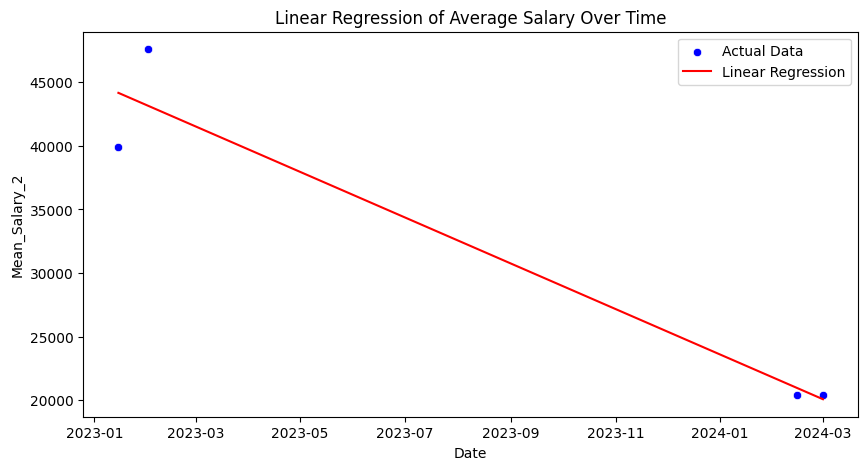

In [82]:
# Convertions les dates en nombres pour la régression
df['Date'] = pd.to_datetime(df['Date'])
df['Date_num'] = df['Date'].map(pd.Timestamp.toordinal)

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Préparation des données pour l'entraînement
X = df[['Date_num']]
y = df['Mean_Salary_0']

# Entrainement du modèle
model.fit(X, y)

df['Predictions'] = model.predict(X)

# Traçage du graphique
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Date', y='Mean_Salary_0', data=df, color='blue', label='Actual Data')
sns.lineplot(x='Date', y='Predictions', data=df, color='red', label='Linear Regression')

plt.xlabel('Date')
plt.ylabel('Mean_Salary_0')
plt.title('Linear Regression of Average Salary Over Time')
plt.legend()
plt.show()

Nous faisons de même pour les valeurs count (nombre d'annonce en ligne par type)

In [77]:
# Nous établissons la bibliothèque data comprenant chaque type d'emploi, les données du 15/01 sont celles scrappées, les suivantes sont établies aléatoirement pour tester la régression
data = {
    'Date': ['01/15/2023', '02/01/2023', '02/15/2024', '03/01/2024',],
    'Mean_Count_0': [count_salaries[0], count_salaries[0]*random_number0, count_salaries[0]*random_number0, count_salaries[0]*random_number0],  # Pour Number 1
    'Mean_Count_1': [count_salaries[1], count_salaries[1]*random_number1, count_salaries[1]*random_number1, count_salaries[1]*random_number1],  # Pour Number 2
    'Mean_Count_2': [count_salaries[2], count_salaries[2]*random_number0, count_salaries[2]*random_number2, count_salaries[2]*random_number2],  # Pour Number 2
    'Mean_Count_3': [count_salaries[3], count_salaries[2]*random_number3, count_salaries[2]*random_number3, count_salaries[2]*random_number3],  # Pour Number 2
    'Mean_Count_4': [count_salaries[4], count_salaries[4]*random_number4, count_salaries[4]*random_number4, count_salaries[4]*random_number4],  # Pour Number 2
    'Mean_Count_5': [count_salaries[5], count_salaries[5]*random_number5, count_salaries[5]*random_number5, count_salaries[5]*random_number5],  # Pour Number 2
    'Mean_Count_6': [count_salaries[6], count_salaries[6]*random_number6, count_salaries[6]*random_number6, count_salaries[6]*random_number6],  # Pour Number 2
    'Mean_Count_7': [count_salaries[7], count_salaries[7]*random_number7, count_salaries[7]*random_number7, count_salaries[7]*random_number7],  # Pour Number 2
    
}

# Création du data frame
df = pd.DataFrame(data)

# Transformation des dates en nombres et non en string
df['Date'] = pd.to_datetime(df['Date'])
df['Date_ordinal'] = df['Date'].apply(lambda x: x.toordinal())

# Nous faisons la regression linéaire pour chaque groupe de Number en excluant la colonne 'Date' et 'Date_ordinal'
for col in df.columns[1:-1]: 
    X = df[['Date_ordinal']]
    y = df[col]
    model = LinearRegression()
    model.fit(X, y)

    # Nous affichons les résultats de la régression pour chaque groupe
    print(f"Régression pour {col}:")
    print(f"  Coefficient (pente): {model.coef_[0]}")
    print(f"  Intercept: {model.intercept_}\n")



Régression pour Mean_Salary_0:
  Coefficient (pente): 0.04142654639024368
  Intercept: -30415.917104728305

Régression pour Mean_Salary_1:
  Coefficient (pente): 0.0437982318658858
  Intercept: -32250.628944436594

Régression pour Mean_Salary_2:
  Coefficient (pente): -0.03815030506209952
  Intercept: 28204.08507147045

Régression pour Mean_Salary_3:
  Coefficient (pente): -0.11748298710340702
  Intercept: 86831.65298186058

Régression pour Mean_Salary_4:
  Coefficient (pente): 0.011209704973471154
  Intercept: -8254.690475717258

Régression pour Mean_Salary_5:
  Coefficient (pente): -0.006304911653328871
  Intercept: 4668.109321476997

Régression pour Mean_Salary_6:
  Coefficient (pente): -0.014841070201612664
  Intercept: 10989.262652974898

Régression pour Mean_Salary_7:
  Coefficient (pente): -0.00041348786637787903
  Intercept: 306.22517031794837



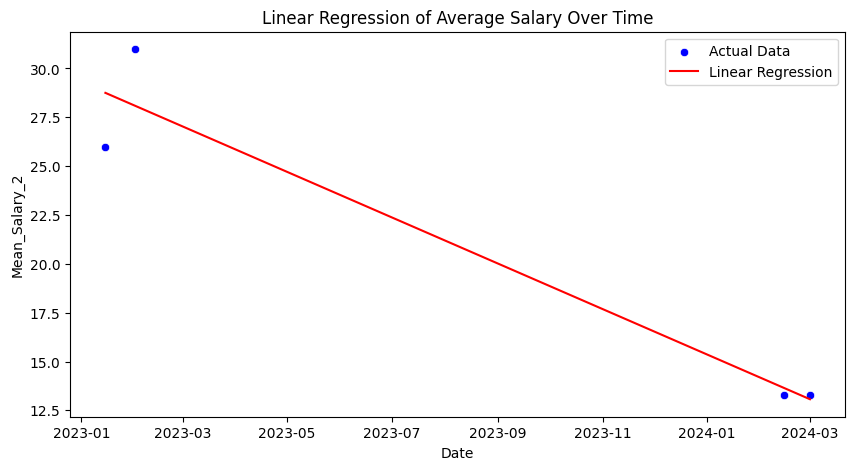

In [80]:
# Convertions les dates en nombres pour la régression
df['Date'] = pd.to_datetime(df['Date'])
df['Date_num'] = df['Date'].map(pd.Timestamp.toordinal)

# Initialisation du modèle de régression linéaire
model = LinearRegression()

# Préparation des données pour l'entraînement
X = df[['Date_num']]
y = df['Mean_Count_0']

# Entrainement du modèle
model.fit(X, y)

df['Predictions'] = model.predict(X)

# Traçage du graphique
plt.figure(figsize=(10, 5))
sns.scatterplot(x='Date', y='Mean_Count_0', data=df, color='blue', label='Actual Data')
sns.lineplot(x='Date', y='Predictions', data=df, color='red', label='Linear Regression')

plt.xlabel('Date')
plt.ylabel('Mean_Count_0')
plt.title('Linear Regression of Average Salary Over Time')
plt.legend()
plt.show()